# Title

In [1]:
!pip install -U tensorflow==2.8 wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

## Enable w&b logging

In [2]:
import wandb
wandb.login(key="fd9f24c89ea44085597d8689ee2472b1a6261015")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
config={
    "architecture": "MobileNetV2",
    "input_shape": (224, 224, 3),
    "epochs": 15,
    "batch_size": 32,
    "seed": 44,
    "use_small_sample": False,
}

In [4]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ai-detection",

    # track hyperparameters and run metadata with wandb.config
    config=config
)

wandb: Currently logged in as: m-lechow13 (budalema). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240505_160646-df1jn6cx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dark-parsec-52
wandb: ⭐️ View project at https://wandb.ai/budalema/ai-detection
wandb: 🚀 View run at https://wandb.ai/budalema/ai-detection/runs/df1jn6cx


## Set seed for reproducability

In [5]:
import numpy as np
import tensorflow as tf

SEED = config["seed"]

# Set random seed for NumPy
np.random.seed(SEED)

# Set random seed for TensorFlow
tf.random.set_seed(SEED)

## Import data

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"

TARGET_SIZE = (config["input_shape"][0], config["input_shape"][1])
BATCH_SIZE = config["batch_size"]

image_generator = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to [0, 1]
    validation_split=0.1,  # split data into training and validation sets
    # other augmentation parameters can be added here
)

train_data_gen = image_generator.flow_from_directory(
    directory=data_path,
    batch_size=BATCH_SIZE,
    target_size=TARGET_SIZE,
    class_mode='categorical',
    subset='training',
)

val_data_gen = image_generator.flow_from_directory(
    directory=data_path,
    batch_size=BATCH_SIZE,
    target_size=TARGET_SIZE,
    class_mode='categorical',
    subset='validation',
)


test_data_path = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"
test_image_generator = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to [0, 1]
)
test_data_gen = test_image_generator.flow_from_directory(
    directory=test_data_path,
    batch_size=BATCH_SIZE,
    target_size=TARGET_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=False,
)

Found 90000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [7]:
# Get the class encoding from the generator
class_encoding = test_data_gen.class_indices

# Print the class encoding
print("Class Encoding:", class_encoding)

Class Encoding: {'FAKE': 0, 'REAL': 1}


## Load and show sample image

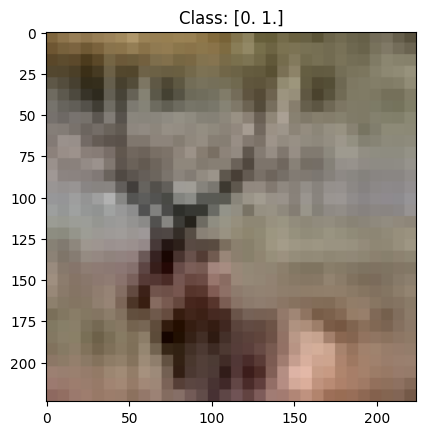

In [8]:
import matplotlib.pyplot as plt

# Retrieve a batch of data from the generator
batch_images, batch_labels = train_data_gen[0]

# Display the sample image(s)
for i in range(1):
    plt.imshow(batch_images[i])
    plt.title('Class: {}'.format(batch_labels[i]))
#     plt.axis('off')
    plt.show()

## Load the model

In [9]:
from tensorflow.keras.applications import MobileNetV2

NUMBER_OF_CLASSES = 2

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=config['input_shape'],
)

# Freeze the pre-trained layers
base_model.trainable = False

base_model.summary()

9420800/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [10]:
from tensorflow.keras import layers

# Define input layer
# inputs = layers.Input(shape=config["input_shape"])

# Include base model
# X = base_model()

# Add new head layer 
X = layers.GlobalAveragePooling2D()(base_model.output)
X = layers.Dense(128, activation='relu')(X)
outputs = layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(X)

# define model
keras_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

In [12]:
from wandb.keras import WandbCallback

EPOCHS = config["epochs"]

if config["use_small_sample"] is True:
    steps_per_epoch = 1000 // BATCH_SIZE
    validation_steps = 100 // BATCH_SIZE
else:
    # train_data_gen.samples // BATCH_SIZE
    steps_per_epoch = None
    validation_steps = None
    
print(f"steps_per_epoch = {steps_per_epoch}, validation_steps = {validation_steps}\n\n")

steps_per_epoch = None, validation_steps = None




In [13]:
history = keras_model.fit(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[
      WandbCallback(generator=val_data_gen),
    ],
    validation_steps=validation_steps
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
2813/2813 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8878

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240505_160646-df1jn6cx/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 2772s 984ms/step - loss: 0.2695 - accuracy: 0.8878 - val_loss: 0.2669 - val_accuracy: 0.8882
Epoch 2/15
2813/2813 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9086

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240505_160646-df1jn6cx/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 2732s 971ms/step - loss: 0.2234 - accuracy: 0.9086 - val_loss: 0.2190 - val_accuracy: 0.9100
Epoch 3/15
2813/2813 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9172

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240505_160646-df1jn6cx/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 2724s 968ms/step - loss: 0.2042 - accuracy: 0.9172 - val_loss: 0.1969 - val_accuracy: 0.9202
Epoch 4/15
2813/2813 [==============================] - 2668s 949ms/step - loss: 0.1915 - accuracy: 0.9231 - val_loss: 0.2082 - val_accuracy: 0.9144
Epoch 5/15
2813/2813 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9279

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240505_160646-df1jn6cx/files/model-best)... Done. 0.1s


2813/2813 [==============================] - 2705s 962ms/step - loss: 0.1801 - accuracy: 0.9279 - val_loss: 0.1821 - val_accuracy: 0.9291
Epoch 6/15
2813/2813 [==============================] - 2723s 968ms/step - loss: 0.1716 - accuracy: 0.9316 - val_loss: 0.2086 - val_accuracy: 0.9154
Epoch 7/15
2813/2813 [==============================] - 2650s 941ms/step - loss: 0.1640 - accuracy: 0.9344 - val_loss: 0.1839 - val_accuracy: 0.9281
Epoch 8/15
2813/2813 [==============================] - 2533s 900ms/step - loss: 0.1564 - accuracy: 0.9374 - val_loss: 0.1997 - val_accuracy: 0.9216
Epoch 9/15
2813/2813 [==============================] - 2458s 874ms/step - loss: 0.1496 - accuracy: 0.9408 - val_loss: 0.2000 - val_accuracy: 0.9224
Epoch 10/15
2813/2813 [==============================] - 2547s 905ms/step - loss: 0.1415 - accuracy: 0.9439 - val_loss: 0.1853 - val_accuracy: 0.9271
Epoch 11/15
2813/2813 [==============================] - 2504s 890ms/step - loss: 0.1372 - accuracy: 0.9461 - val_lo

In [14]:
wandb.finish()

wandb:                                                                                
wandb: W&B sync reduced upload amount by 1.6%             
wandb: 
wandb: Run history:
wandb:     accuracy ▁▃▄▅▅▆▆▆▆▇▇▇▇██
wandb:        epoch ▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
wandb:         loss █▆▅▄▄▄▃▃▃▂▂▂▂▁▁
wandb: val_accuracy ▁▅▆▅█▅▇▆▇▇▆▇███
wandb:     val_loss █▄▂▃▁▃▁▂▂▁▃▂▁▁▂
wandb: 
wandb: Run summary:
wandb:      accuracy 0.95548
wandb:    best_epoch 4
wandb: best_val_loss 0.18209
wandb:         epoch 14
wandb:          loss 0.11513
wandb:  val_accuracy 0.9313
wandb:      val_loss 0.1907
wandb: 
wandb: 🚀 View run dark-parsec-52 at: https://wandb.ai/budalema/ai-detection/runs/df1jn6cx
wandb: ⭐️ View project at: https://wandb.ai/budalema/ai-detection
wandb: Synced 5 W&B file(s), 1 media file(s), 16 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20240505_160646-df1jn6cx/logs
